In [121]:
import sys
import getpass
import requests
import fiona
import json
import os

user = getpass.getuser()
sys.dont_write_bytecode = True

# for DataViz team members
sys.path.insert(0, '/Users/{}/Box/Utility Code'.format(user))

from utils_io import *

#Geoimports
import geopandas as gp

from matplotlib import pyplot as plt

In [2]:
census_api_key = getpass.getpass()

········


## Pull Decennial Census table variables

In [66]:
rq = requests.get('https://api.census.gov/data/2020/dec/pl/variables.json')
data = rq.json()

In [67]:
tbl_vars = pd.DataFrame.from_dict(data['variables'],orient='index')

In [68]:
tbl_vars.reset_index(inplace=True)

In [69]:
tbl_vars.rename(columns={'index':'name'},inplace=True)

In [70]:
p2_vars = ['P2_001N',
 'P2_002N',
 'P2_003N',
 'P2_004N',
 'P2_005N',
 'P2_006N',
 'P2_007N',
 'P2_008N',
 'P2_009N',
 'P2_010N',
 'P2_011N']
p2_race_vars = tbl_vars[tbl_vars['name'].isin(p2_vars)]

In [71]:
p2_race_vars.to_csv('data/decennial_census_tbl_vars_p2.csv')

## Pull Decennial Census from Census API

summarize not Hispanic/Latino by races you want, an other category, and multi-racial; then all Hispanic/Latino people in one group. That's the standard I see in most places.

In [72]:
acs_vars_lst = p2_race_vars['name'].to_list()

In [73]:
sorted(acs_vars_lst)

['P2_001N',
 'P2_002N',
 'P2_003N',
 'P2_004N',
 'P2_005N',
 'P2_006N',
 'P2_007N',
 'P2_008N',
 'P2_009N',
 'P2_010N',
 'P2_011N']

In [74]:
var = ','.join(acs_vars_lst)
counties = '001,013,041,055,075,081,085,095,097'
state = '06'
base_url = 'https://api.census.gov/data/2020/dec/pl?'

query_params = {
    'get': var,
    'for': 'tract:*',
    'in': [
        f'county:{counties}',
        f'state:{state}',
    ],
    'key': census_api_key
}
rq = requests.get(base_url, params=query_params)
data = rq.json()
acs_df = pd.DataFrame(data[1:],columns=data[0])

In [75]:
acs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   P2_002N  1772 non-null   object
 1   P2_003N  1772 non-null   object
 2   P2_004N  1772 non-null   object
 3   P2_005N  1772 non-null   object
 4   P2_010N  1772 non-null   object
 5   P2_011N  1772 non-null   object
 6   P2_001N  1772 non-null   object
 7   P2_006N  1772 non-null   object
 8   P2_007N  1772 non-null   object
 9   P2_008N  1772 non-null   object
 10  P2_009N  1772 non-null   object
 11  state    1772 non-null   object
 12  county   1772 non-null   object
 13  tract    1772 non-null   object
dtypes: object(14)
memory usage: 193.9+ KB


In [76]:
# Convert columns to numeric
acs_df[acs_vars_lst] = acs_df[acs_vars_lst].apply(pd.to_numeric)

In [77]:
rename_dict = {'P2_001N': 'total_pop',
 'P2_002N': 'hispanic_latino_pop',
 'P2_003N': 'non_hispanic_latino_pop',
 'P2_004N': 'non_hl_pop_one_race',
 'P2_005N': 'non_hl_white',
 'P2_006N': 'non_hl_black',
 'P2_007N': 'non_hl_indian_alaska_native',
 'P2_008N': 'non_hl_asian',
 'P2_009N': 'non_hl_hawaiian_pacific_islander',
 'P2_010N': 'non_hl_other_race',
 'P2_011N': 'non_hl_multi_racial'}
acs_df.rename(columns=rename_dict,inplace=True)

In [78]:
col_order = ['state',
             'county',
             'tract',
             'total_pop',
             'hispanic_latino_pop',
             #'non_hispanic_latino_pop',
             #'non_hl_pop_one_race',
             'non_hl_white',
             'non_hl_black',
             'non_hl_indian_alaska_native',
             'non_hl_asian',
             'non_hl_hawaiian_pacific_islander',
             'non_hl_other_race',
             'non_hl_multi_racial']

In [79]:
acs_df = acs_df[col_order]

In [80]:
#Check that adding columns adds up to total pop
(acs_df.hispanic_latino_pop + 
 acs_df.non_hl_white + 
 acs_df.non_hl_black + 
 acs_df.non_hl_indian_alaska_native + 
 acs_df.non_hl_asian + 
 acs_df.non_hl_hawaiian_pacific_islander + 
 acs_df.non_hl_other_race + 
 acs_df.non_hl_multi_racial)

0         67
1       5887
2       2149
3       5535
4       5447
        ... 
1767    5931
1768    3645
1769    3749
1770    3474
1771    5664
Length: 1772, dtype: int64

In [81]:
#add geoid column
acs_df['GEOID'] = acs_df['state'] + acs_df['county'] + acs_df['tract']

In [82]:
acs_df.head(5)

,state,county,tract,total_pop,hispanic_latino_pop,non_hl_white,non_hl_black,non_hl_indian_alaska_native,non_hl_asian,non_hl_hawaiian_pacific_islander,non_hl_other_race,non_hl_multi_racial,GEOID
0,06,055,200900,67,19,27,2,2,1,1,5,10,06055200900
1,06,055,200802,5887,2243,3128,56,20,170,6,40,224,06055200802
2,06,055,200803,2149,469,1513,16,5,47,1,18,80,06055200803
3,06,055,200804,5535,3943,1372,16,7,55,3,27,112,06055200804
4,06,055,201003,5447,1032,1004,444,7,2578,20,24,338,06055201003


## Pull American community Service Tracts Geodata

### Query Census TIGER Tracts to get Bay Area Census Tract geography

#### [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)

In [83]:
def pull_census_tracts_geodata(year=2020):
    """
    Pulls Census Tracts from TIGERweb REST API and returns Geopandas GeoDataframe. 
    Default year is 2020 which is the latest-available vintage for TIGER tracts. 
    
    Args:
    year (int): the TIGER vintage. 
        list of valid years: [2012,2015,2016,2017,2018,2019,2020]
    
    Author: Joshua Croff
    Source:
    [Census TIGERweb REST API Documentation](https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html)
    """
    import pandas as pd
    valid_years = [2012,2015,2016,2017,2018,2019,2020]
    if year not in valid_years:
        print('Error- vintage not available. Please see docstring for valid years')
    elif year == 2020:
        map_service = f'Generalized_TAB{year}'
    else:
        map_service = f'Generalized_ACS{year}'
    
    state = '06'
    counties = "('001','013','041','055','075','081','085','095','097')"
    where_str = f"where=STATE='{state}'+AND+COUNTY+IN{counties}"
    query_args = [where_str, 'outFields=GEOID&f=geojson']
    url = '/'.join(['https://tigerweb.geo.census.gov',
                    'arcgis',
                    'rest',
                    'services',
                    map_service,
                    'Tracts_Blocks',
                    'MapServer',
                    '3',
                    'query?{}'.format('&'.join(query_args))])
    r = get_http_response(url)
    geog_json = r.json()
    geog_gdf = gp.GeoDataFrame.from_features(geog_json['features'],
                                        crs='EPSG:4326')
    return geog_gdf

In [84]:
bay_area_tracts = pull_census_tracts_geodata()

In [85]:
bay_area_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1765 entries, 0 to 1764
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  1765 non-null   geometry
 1   GEOID     1765 non-null   object  
dtypes: geometry(1), object(1)
memory usage: 27.7+ KB


In [86]:
bay_area_tracts.head(5)

,geometry,GEOID
0,"POLYGON ((-122.24691 37.88535, -122.24683 37.8...",06001400100
1,"POLYGON ((-122.25742 37.84310, -122.25792 37.8...",06001400200
2,"POLYGON ((-122.26416 37.84000, -122.26563 37.8...",06001400300
3,"POLYGON ((-122.26181 37.84179, -122.26186 37.8...",06001400400
4,"POLYGON ((-122.26941 37.84811, -122.26923 37.8...",06001400500


## Join data to bay area tracts

In [87]:
race_tracts = pd.merge(bay_area_tracts,
                       acs_df,
                      on='GEOID',
                      how='inner')

In [88]:
race_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1765 entries, 0 to 1764
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   geometry                          1765 non-null   geometry
 1   GEOID                             1765 non-null   object  
 2   state                             1765 non-null   object  
 3   county                            1765 non-null   object  
 4   tract                             1765 non-null   object  
 5   total_pop                         1765 non-null   int64   
 6   hispanic_latino_pop               1765 non-null   int64   
 7   non_hl_white                      1765 non-null   int64   
 8   non_hl_black                      1765 non-null   int64   
 9   non_hl_indian_alaska_native       1765 non-null   int64   
 10  non_hl_asian                      1765 non-null   int64   
 11  non_hl_hawaiian_pacific_islander  1765 non-null 

In [89]:
race_tracts.columns.to_list()

['geometry',
 'GEOID',
 'state',
 'county',
 'tract',
 'total_pop',
 'hispanic_latino_pop',
 'non_hl_white',
 'non_hl_black',
 'non_hl_indian_alaska_native',
 'non_hl_asian',
 'non_hl_hawaiian_pacific_islander',
 'non_hl_other_race',
 'non_hl_multi_racial']

In [90]:
reorder_cols = [
    'GEOID',
    'state',
    'county',
    'tract',
    'total_pop',
    'hispanic_latino_pop',
    'non_hl_white',
    'non_hl_black',
    'non_hl_indian_alaska_native',
    'non_hl_asian',
    'non_hl_hawaiian_pacific_islander',
    'non_hl_other_race',
    'non_hl_multi_racial',
    'geometry'
]

In [91]:
race_tracts = race_tracts[reorder_cols]

## Read 880 corridor data

In [92]:
fgdb = '/Users/jcroff/Box/DataViz Projects/Adhoc-Spatial-Analysis/FastTrak Start Pilot Mapping/arcgis_projects/FastTrak START Pilot Mapping/FastTrak START Pilot Mapping.gdb'

In [93]:
fiona.listlayers(fgdb)

['tomtom_2019_road_highway_interstate',
 'tomtom_2019_interstate_880',
 'interstate_880_corridor_study_area',
 'Expresslanes_880',
 'coc_study_area',
 'low_income_language_at_home_acs2014_2018',
 'low_income_language_at_home_acs2014_2018_study_area',
 'Low_Income_Tracts']

In [94]:
corridor_study_area = gp.read_file(fgdb,driver='FileGDB',
                                   layer='interstate_880_corridor_study_area')

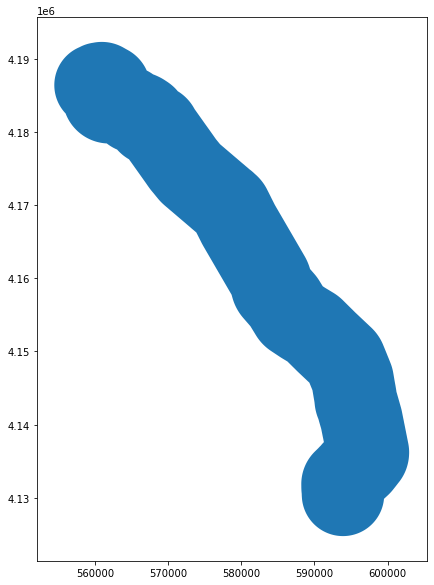

In [95]:
corridor_study_area.plot(figsize=(10,10));

In [96]:
corridor_study_area

,Shape_Length,Shape_Area,geometry
0,179469.390878,9.200699e+08,"MULTIPOLYGON (((593967.487 4124752.215, 593964..."


In [97]:
#Project to wgs84
corridor_study_area.to_crs('EPSG:4326',inplace=True)

In [98]:
corridor_study_area.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Clip census tracts to study area

In [99]:
race_tracts_clip = gp.clip(race_tracts,
                           corridor_study_area)

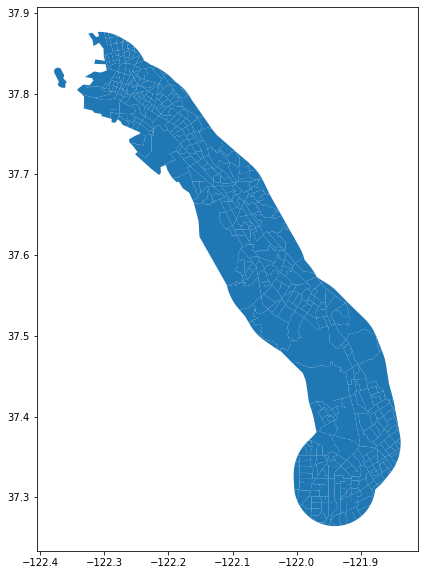

In [100]:
race_tracts_clip.plot(figsize=(10,10));

In [101]:
race_tracts_clip.columns.to_list()

['GEOID',
 'state',
 'county',
 'tract',
 'total_pop',
 'hispanic_latino_pop',
 'non_hl_white',
 'non_hl_black',
 'non_hl_indian_alaska_native',
 'non_hl_asian',
 'non_hl_hawaiian_pacific_islander',
 'non_hl_other_race',
 'non_hl_multi_racial',
 'geometry']

## Summarize data

In [159]:
summary_cols = ['total_pop',
 'hispanic_latino_pop',
 'non_hl_white',
 'non_hl_black',
 'non_hl_indian_alaska_native',
 'non_hl_asian',
 'non_hl_hawaiian_pacific_islander',
 'non_hl_other_race',
 'non_hl_multi_racial']
study_area_summary = race_tracts_clip[summary_cols].aggregate('sum').to_frame().T

In [160]:
def create_multiple_share_columns(dataframe, dictionary, total_population_column):
    for key, value in dictionary.items():
        dataframe[value] = np.where(dataframe[total_population_column] == 0,0,
                                    (dataframe[key] /
                                     dataframe[total_population_column]))

In [161]:
dict.fromkeys(summary_cols,'')

{'total_pop': '',
 'hispanic_latino_pop': '',
 'non_hl_white': '',
 'non_hl_black': '',
 'non_hl_indian_alaska_native': '',
 'non_hl_asian': '',
 'non_hl_hawaiian_pacific_islander': '',
 'non_hl_other_race': '',
 'non_hl_multi_racial': ''}

In [162]:
summary_cols_pct_dict = {
 'hispanic_latino_pop': 'pct_hispanic_latino_pop',
 'non_hl_white': 'pct_non_hl_white',
 'non_hl_black': 'pct_non_hl_black',
 'non_hl_indian_alaska_native': 'pct_non_hl_indian_alaska_native',
 'non_hl_asian': 'pct_non_hl_asian',
 'non_hl_hawaiian_pacific_islander': 'pct_non_hl_hawaiian_pacific_islander',
 'non_hl_other_race': 'pct_non_hl_other_race',
 'non_hl_multi_racial': 'pct_non_hl_multi_racial'}

In [163]:
create_multiple_share_columns(study_area_summary,
                              dictionary=summary_cols_pct_dict,
                              total_population_column='total_pop')

In [164]:
study_area_summary_transpose = study_area_summary.T

In [165]:
study_area_summary_transpose.rename(columns={0:'Summary_Statistics'},inplace=True)

In [166]:
study_area_summary_transpose.to_csv('data/study_area_race_summary_Census2020.csv')

## Graph data

In [172]:
study_area_summary_transpose

,Summary_Statistics
total_pop,2.167073e+06
hispanic_latino_pop,5.569890e+05
non_hl_white,5.310620e+05
non_hl_black,1.730880e+05
non_hl_indian_alaska_native,4.839000e+03
non_hl_asian,7.724850e+05
non_hl_hawaiian_pacific_islander,1.520200e+04
non_hl_other_race,1.269100e+04
non_hl_multi_racial,1.007170e+05
pct_hispanic_latino_pop,2.570236e-01


In [181]:
graph_sum_cols = ['pct_hispanic_latino_pop',
 'pct_non_hl_white',
 'pct_non_hl_black',
 'pct_non_hl_indian_alaska_native',
 'pct_non_hl_asian',
 'pct_non_hl_hawaiian_pacific_islander',
 'pct_non_hl_other_race',
 'pct_non_hl_multi_racial']
study_area_pct = study_area_summary_transpose.loc[graph_sum_cols]

In [182]:
index_rename = {'pct_hispanic_latino_pop':'Hispanic or Latino',
               'pct_non_hl_white':'White',
               'pct_non_hl_black':'Black',
               'pct_non_hl_indian_alaska_native':'Native American + Alaskan',
               'pct_non_hl_asian':'Asian',
               'pct_non_hl_hawaiian_pacific_islander':'Hawaiian Pacific Islander',
               'pct_non_hl_other_race':'Other',
               'pct_non_hl_multi_racial':'Multiracial'}
study_area_pct.rename(index=index_rename,inplace=True)

In [183]:
study_area_pct.index

Index(['Hispanic or Latino', 'White', 'Black', 'Native American + Alaskan',
       'Asian', 'Hawaiian Pacific Islander', 'Other', 'Multiracial'],
      dtype='object')

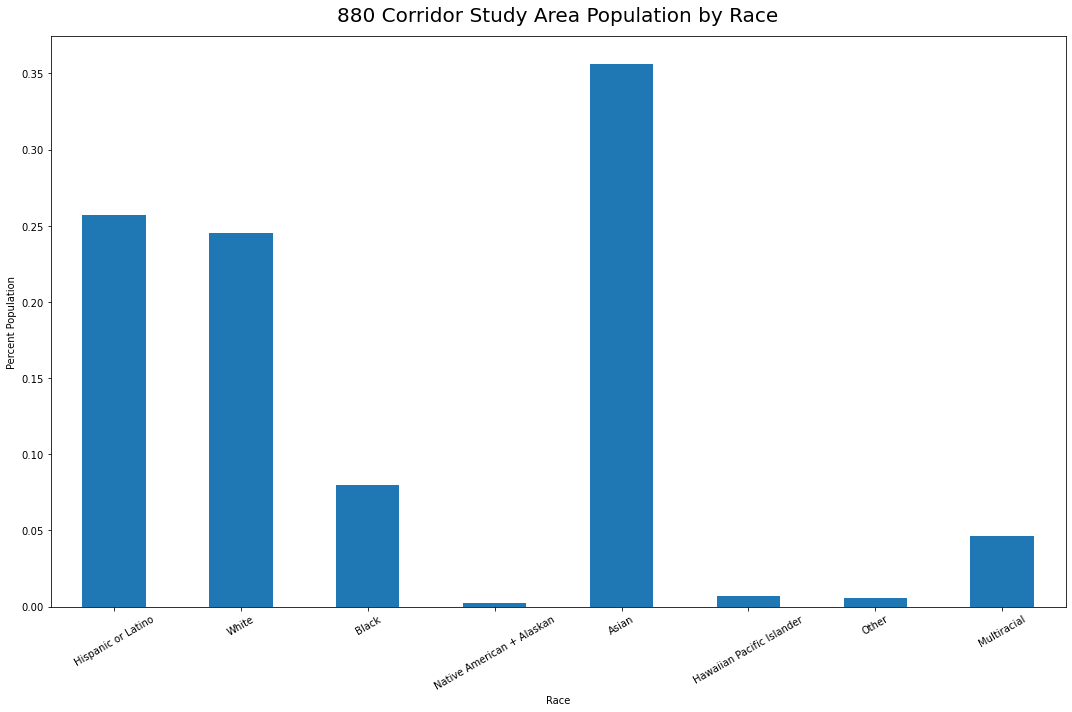

In [186]:
plot_cols = ['Hispanic or Latino', 'White Alone', 'Black Alone',
       'Indian or Alaska Native Alone', 'Asian Alone',
       'Hawaiian or Pacific Islander', 'Other Race Alone', 'Multi Racial']
study_area_pct.plot(kind='bar',figsize=(15,10),rot=30,legend=False)

plt.title("880 Corridor Study Area Population by Race",
          fontdict={'fontsize':20},
          pad=15)
plt.xlabel("Race")
plt.ylabel("Percent Population")
plt.ticklabel_format(style='plain',axis='y')
plt.tight_layout()
plt.savefig('data/study_area_population_by_race.png',facecolor='white',dpi=350);